In [1]:
from pathlib import Path

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from mne.io.eeglab.eeglab import _check_load_mat

import acareeg

In [2]:
recompute = False
mastersheet = acareeg.eegip.get_mastersheet()
mastersheet = mastersheet.reset_index()[["Site", "ID", '6m_EEGLAB_QCR_File', "sex", "Risk Group", "outcome",
                                         '12m_EEGLAB_QCR_File', '18m_EEGLAB_QCR_File']]
mastersheet = mastersheet.dropna(how="all")
mastersheet = mastersheet[mastersheet.Site != "Boston"]
mastersheet.rename(columns={"Site": "dataset", "ID": "subject_no", "Risk Group": "risk"}, inplace=True)
mastersheet["subject_no"] = [int(subject[-3:]) if isinstance(subject, str) else subject 
                             for subject in mastersheet["subject_no"]]

mastersheet = mastersheet.dropna(how="all")
mastersheet.loc[mastersheet.risk == "High Risk", "risk"] = "HRA"
mastersheet.loc[mastersheet.risk == "High Risk_12mo", "risk"] = "HRA"
mastersheet.loc[mastersheet.risk == "Low Risk", "risk"] = "Control"
mastersheet.loc[mastersheet.risk == "Low Risk_12mo", "risk"] = "Control"
mastersheet.dataset = mastersheet.dataset.str.lower()

mastersheet.loc[(mastersheet.outcome == "asd") & (mastersheet.risk == "HRA"), "group"] = "ELA-ASD"
mastersheet.loc[(mastersheet.outcome == "no-asd") & (mastersheet.risk == "HRA"), "group"] = "ELA-noASD"
mastersheet.loc[(mastersheet.outcome == "no-asd") & (mastersheet.risk == "Control"), "group"]  = "TLA"
mastersheet.loc[(mastersheet.outcome == 777) & (mastersheet.risk == "Control"), "group"]  = "TLA"

mastersheet["group"] = pd.Categorical(mastersheet.group, categories=["TLA", "ELA-noASD", "ELA-ASD"], ordered=True)    


con_path = Path("/Volumes/usc_data/ElementSE/eegip/con_paper/")
bids_root = Path("/Volumes/usc_data/ElementSE/eegip")
subjects_dir = "."

In [3]:
recompute = False

if recompute:
    subjects = []
    ages = []
    sites = []
    sexes = []
    bad_ch = []
    bad_ic = []

    for index, row in tqdm(mastersheet.iterrows(), total=len(mastersheet)):
        dataset = row.Site.lower()
        for age in [6, 12, 18]:

            subject = int(row.subject_no)
            age = int(age)
            eeg_path = Path(bids_root) / dataset / "derivatives" / "lossless" / f"sub-s{subject:03}" / f"ses-m{age:02}" / "eeg"
            eeg_path = list(eeg_path.glob("*_qcr.set"))
            if len(eeg_path) == 0:
                continue
            eeg_path = eeg_path[0]
            print(eeg_path)
            raw = acareeg.eegip.preprocessed_raw(eeg_path, acareeg.eegip.line_freqs[dataset], 
                                montage=None, apply_ica=False, interp_bad_ch=False, 
                                reset_bads=False)

            subjects.append(subject)
            ages.append(age)
            sites.append(dataset)
            sexes.append(row.sex)
            bad_ch.append(np.sum(~np.in1d(raw.info["bads"], acareeg.eegip.eog_channels))/(len(raw.ch_names) - len(acareeg.eegip.eog_channels)))

            raw_eeg = _check_load_mat(eeg_path, None)
            mark_to_remove = ["manual"]
            comp_info = raw_eeg.marks["comp_info"]

            if len(np.array(comp_info["flags"]).shape) > 1:
                ind_comp_to_drop = np.unique(np.concatenate([np.where(flags)[0] for flags, label in zip(comp_info["flags"],
                                                                                                        comp_info["label"])
                                                            if label in mark_to_remove]))
            else:
                ind_comp_to_drop = np.where(comp_info["flags"])[0]

            bad_ic.append(len(ind_comp_to_drop)/len(comp_info["flags"][0]))

    pd.DataFrame(dict(subject = subjects,
                        age = ages,
                        site = sites,
                        sexe = sexes,
                        bad_ch = bad_ch,
                        bad_ic = bad_ic)).to_csv("artifact_dist.csv")            

In [4]:
art_df = pd.read_csv("artifact_dist.csv", index_col=0)
art_df["bad_ch"] *= 100
art_df["bad_ic"] *= 100
art_df = art_df[art_df.age != 18]
art_df = art_df.merge(mastersheet[["subject_no", 'group']], left_on="subject", right_on="subject_no").dropna()
art_df

,subject,age,site,sexe,bad_ch,bad_ic,subject_no,group
0,601,6,london,F,18.644068,29.292929,601,ELA-ASD
1,601,12,london,F,11.864407,29.090909,601,ELA-ASD
3,603,6,london,M,7.627119,72.807018,603,ELA-noASD
4,603,12,london,M,28.813559,55.294118,603,ELA-noASD
5,604,6,london,M,19.491525,51.960784,604,ELA-noASD
...,...,...,...,...,...,...,...,...
335,166,12,washington,M,15.254237,83.653846,166,TLA
336,915,6,washington,M,23.728814,37.500000,915,TLA
337,915,12,washington,M,12.711864,55.963303,915,TLA
340,937,6,washington,M,22.881356,86.597938,937,TLA


In [5]:
art_df.max()

subject              937
age                   12
site          washington
sexe                   M
bad_ch         51.694915
bad_ic         91.150442
subject_no           937
group            ELA-ASD
dtype: object

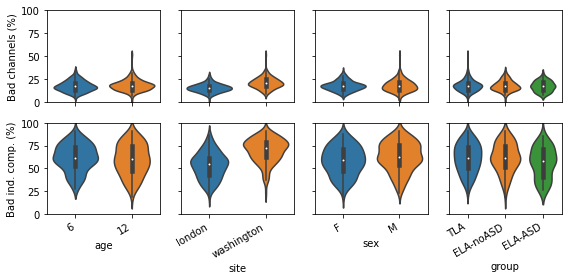

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 4, sharex="col", sharey="row", figsize=(8, 4))

for variable, ax_row in zip(["bad_ch", "bad_ic"], axes):
    for factor, ax in zip(["age", "site", "sexe", "group"], ax_row):
        sns.violinplot(data=art_df, y=variable, x=factor, ax=ax)
        ax.set_ylim(0, 100)

axes[0, 0].set_ylabel("Bad channels (%)") 
axes[1, 0].set_ylabel("Bad ind. comp. (%)")        
for ax in axes[0]:
    ax.set_xlabel("") 
axes[1, 2].set_xlabel("sex")
for ax in axes[:, 1:].ravel():
    ax.set_ylabel("") 

for ax in axes[1]:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=30, ha='right')

fig.tight_layout()
fig.savefig("images/art_reject.png", dpi=300)

In [10]:
import statsmodels.formula.api as smf

for variable, ax_row in zip(["bad_ch", "bad_ic"], axes):
    model = smf.mixedlm(data=art_df, formula=variable + "~ age + site + sexe + group", groups="subject_no").fit()
    print(model.summary())
    print(model.pvalues)

            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  bad_ch    
No. Observations:    335      Method:              REML      
No. Groups:          184      Scale:               22.5832   
Min. group size:     1        Log-Likelihood:      -1026.3738
Max. group size:     2        Converged:           Yes       
Mean group size:     1.8                                     
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          14.487    0.973 14.893 0.000 12.581 16.394
site[T.washington]  5.691    0.642  8.865 0.000  4.432  6.949
sexe[T.M]          -0.808    0.636 -1.269 0.204 -2.055  0.440
group[T.ELA-noASD]  0.047    0.687  0.068 0.945 -1.299  1.393
group[T.ELA-ASD]   -0.254    0.910 -0.279 0.780 -2.038  1.530
age                 0.154    0.087  1.757 0.079 -0.018  0.325
subject_no Var      

Bad pipe message: %s [b'\xcb\xd4,\xf5\x14\x12l\xebIFS\xd4\x1c\xf7\xa7+\xcav 1\xef\x97\xd34\x17a\x94{s\x8fQ\xdc\xe9\x05\xf6\xa1\xe20@;Sk\x9a\xf4\x15\xd9\xb56\xd0\xe4\x84\x00 ::\x13\x01\x13\x02\x13\x03\xc0+\xc0']
Bad pipe message: %s [b',\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\x93\x8a\x8a\x00\x00\x003\x00+\x00)\x8a\x8a\x00\x01\x00\x00\x1d\x00 \xb6z\xd7\xa0']
Bad pipe message: %s [b'\x9cG\xe4\x87\xcb\x98\xb5\x04\xa9\xe7\xa8\xbb\xd4\xea\xc6\t\xc6\xb5f\x17\xb7"\x10\x08H\x1c\x00\x05\x00\x05\x01\x00\x00\x00\x00\xff\x01\x00\x01\x00Di\x00\x05\x00\x03\x02h2\x00\x17\x00\x00\x00\r\x00\x12\x00\x10\x04\x03\x08\x04\x04\x01\x05\x03\x08']
Bad pipe message: %s [b'\x01\x08\x06\x06', b'']
Bad pipe message: %s [b'\x02\x01\x01\x00\x0b\x00\x02\x01\x00\x00+\x00\x07\x06\xba\xba\x03\x04\x03\x03\x00\x12\x00\x00\x00\x10\x00\x0e\x00\x0c\x02h2\x08http/1.1\x00\n']
Bad pipe message: %s [b'w\x7f\xc9b_\xaf$\x98\x1aUN|\x04&*\xe2\x0cM "\xd2\t\x00\x06\x94\xcc\x8b\x9d\xac\x03\xe2\xe0\xba